<center>
<h2>Sequence Generation using Flipflop network</h2>
</center>

<b>Toy example:</b>

- Train the network to produce sequence when corresponding label is given

<b>Why?</b>
- Can demonstrate the ability of network to memorize the whole series and identify different classes
- The problem subsume prediction and classification as they are relatively easier sequential problems

<b>Implementation</b>
- Uses `Keras` subclass API feature to allow flexible integration over other API elements

  *For example to create a FF layer that return states and sequences and also be stateful*

  ```python

  import FF  # flipflop network
  # Syntactic sugar by Keras API styled definition
  FF(n, return_sequences=True, return_state=True, stateful=True) 

  # Equivalent LSTM definition would look something like,
  tf.keras.layers.LSTM(n, return_sequences=True, return_state=True, stateful=True)

  ```



**Data generation**

In [8]:
import numpy as np

ts = 100

def return_data():
  """
  Generate data
  """
  d1_a1, d1_a2, d1_a3 = np.random.rand(3)
  d1_f1, d1_f2, d1_f3 = np.random.uniform(-100, 50, 3)
  d1_p1, d1_p2, d1_p3 = np.random.uniform(-5, 5, 3)
  data = (d1_a1 * np.cos(d1_f1 * np.arange(0, 10, .1) + d1_p1) +
          d1_a3 * np.sin(d1_f3 * np.arange(0, 10, .1) - d1_p3))
  data = data.reshape(ts, 1)
  data = np.repeat(data, 16, axis=1)
  return data

data_1 = return_data()
data_2 = return_data()

data = np.hstack((data_1, data_2)).T
data = data.reshape(data.shape[0], data.shape[1], 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
data.shape

(32, 100, 1)

Let us visualize the synthesized data

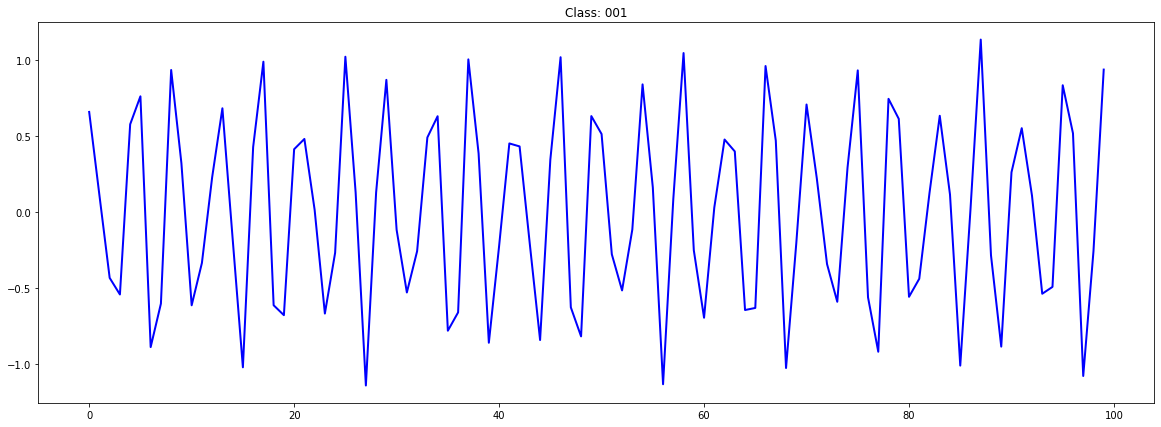

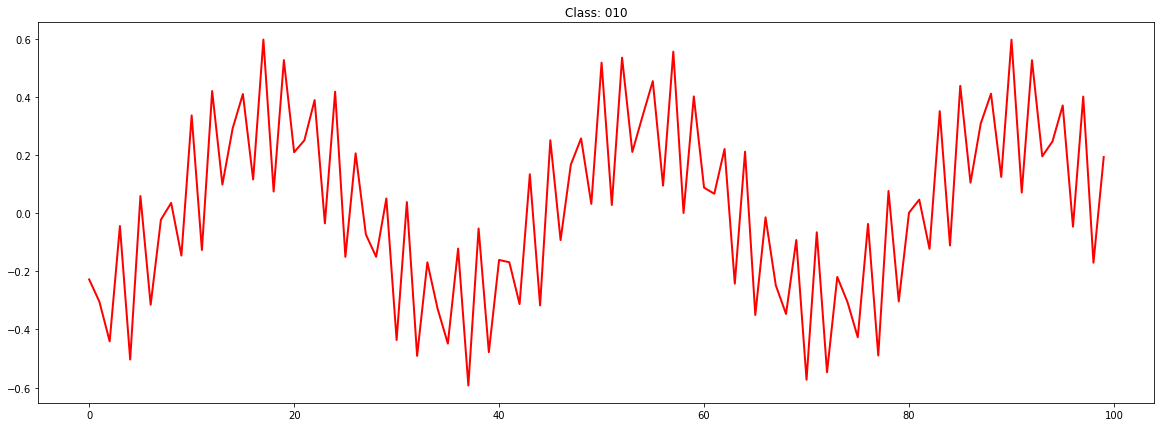

In [70]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(data[np.random.randint(0, 16), :, :], linewidth=2, color='b')
plt.title("Class: 001")
plt.savefig('001.png')
plt.show()

plt.plot(data[np.random.randint(16, 32), :, :], linewidth=2, color='r')
plt.title("Class: 010")
plt.savefig('010.png')

Let us create labels `001` and `011` as the two labels for the generated data

In [10]:
def return_labels(label):
  label_1 = np.array(label).reshape(1, 1, 3)
  label_1 = np.repeat(label_1, ts, axis=1)
  label_1 = np.repeat(label_1, 16, axis=0)
  return label_1

label_1 = return_labels([0, 0, 1])
label_2 = return_labels([0, 1, 0])

label = np.vstack((label_1, label_2))
label.shape

(32, 100, 3)

Implementation of FF layer by subclassing `Keras.layers.Layer`

In [11]:
import tensorflow as tf

class FF(tf.keras.layers.Layer):

    def __init__(self, units, **kwargs):
        super(FF, self).__init__(**kwargs)
        self.units = units
        self.state_size = units
        self.j_h = tf.keras.layers.Dense(self.units)
        self.j_x = tf.keras.layers.Dense(self.units)
        self.k_h = tf.keras.layers.Dense(self.units)
        self.k_x = tf.keras.layers.Dense(self.units)

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        j = tf.sigmoid(self.j_x(inputs) + self.j_h(prev_output))
        k = tf.sigmoid(self.k_x(inputs) + self.k_h(prev_output))
        output = j * (1 - prev_output) + (1 - k) * prev_output
        return output, [output]

Create a sequential model and add `FF` layer

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import TimeDistributed

X = label
Y = data
model = Sequential()
model.add(RNN(FF(50), input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(RNN(FF(50), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 100, 50)           5500      
_________________________________________________________________
rnn_1 (RNN)                  (None, 100, 50)           10200     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 1)            51        
Total params: 15,751
Trainable params: 15,751
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.fit(X, Y, epochs=2000, verbose=0, batch_size=16, shuffle=True)

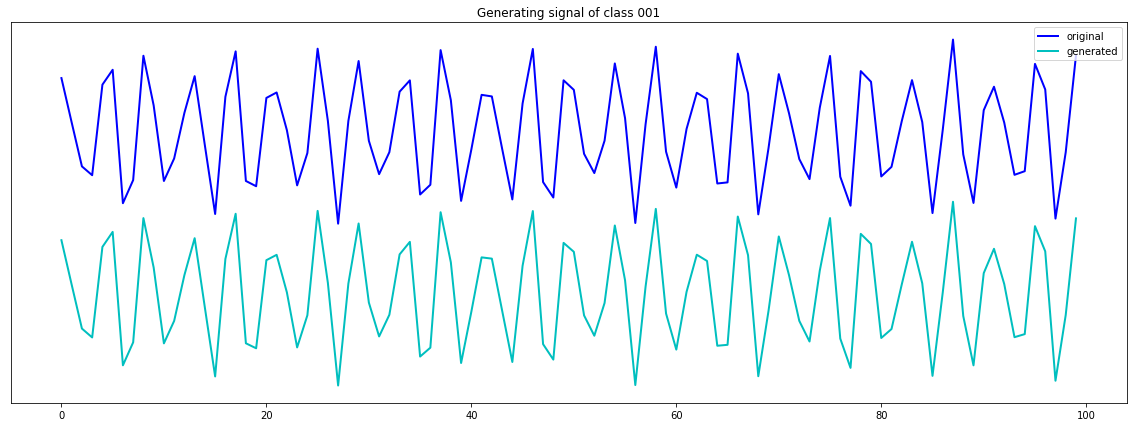

In [63]:
sample = X[2]
original = Y[2]
sample = sample.reshape(1, sample.shape[0], sample.shape[1])
out_p = model.predict(sample)
plt.plot(2 + original.reshape(-1), label="original", linewidth=2, color='b')
plt.plot(out_p.reshape(-1), label="generated", linewidth=2, color='c')
plt.title("Generating signal of class 001")
plt.legend(loc = 'upper right')
plt.yticks([])
plt.savefig('ff_pred_001.png')

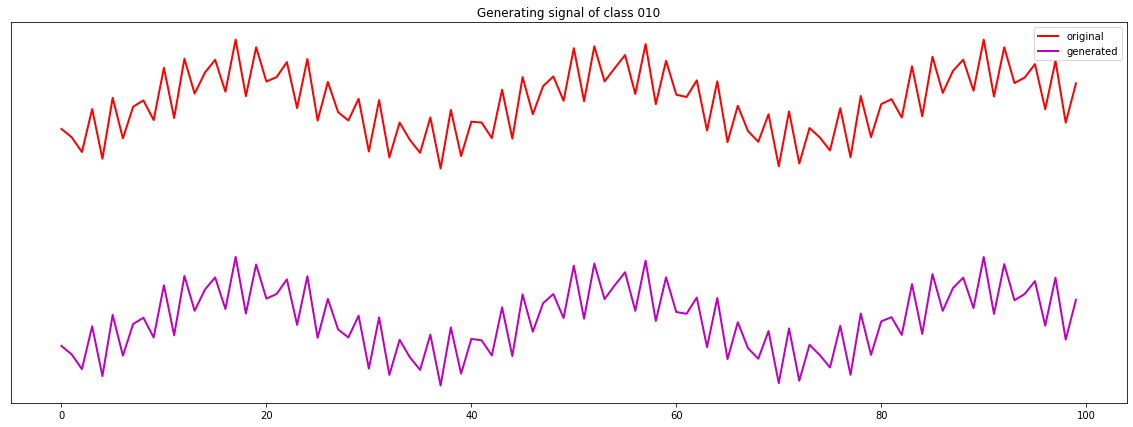

In [64]:
sample = X[18]
original = Y[18]
sample = sample.reshape(1, sample.shape[0], sample.shape[1])
out_p1 = model.predict(sample)
plt.plot(2 + original.reshape(-1), label="original", linewidth=2, color='r')
plt.plot(out_p1.reshape(-1), label="generated", linewidth=2, color='m')
plt.title("Generating signal of class 010")
plt.legend(loc = 'upper right')
plt.yticks([])
plt.savefig('ff_pred_010.png')

In [53]:
model1 = Sequential()
model1.add(tf.keras.layers.LSTM(50, input_shape=(X.shape[1], X.shape[2]), 
                                return_sequences=True))
model1.add(tf.keras.layers.LSTM(50, return_sequences=True))
model1.add(TimeDistributed(Dense(1)))
model1.compile(loss='mean_squared_error', optimizer='adam')
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 1)            51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
model.fit(X, Y, epochs=2000, verbose=0, batch_size=16, shuffle=True)

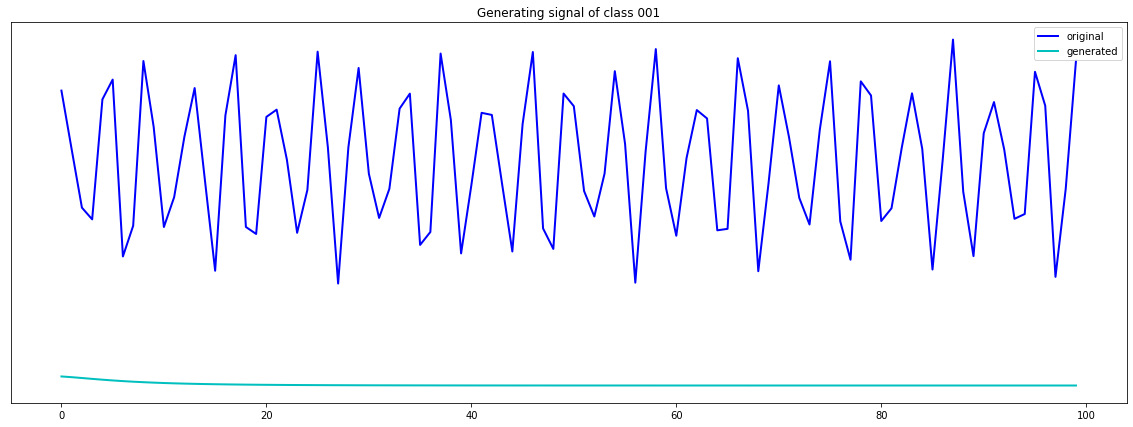

In [65]:
sample = X[2]
original = Y[2]
sample = sample.reshape(1, sample.shape[0], sample.shape[1])
lstm_out_p = model1.predict(sample)
plt.plot(2 + original.reshape(-1), label="original", linewidth=2, color='b')
plt.plot(lstm_out_p.reshape(-1), label="generated", linewidth=2, color='c')
plt.title("Generating signal of class 001")
plt.legend(loc = 'upper right')
plt.yticks([])
plt.savefig('lstm_pred_001.png')

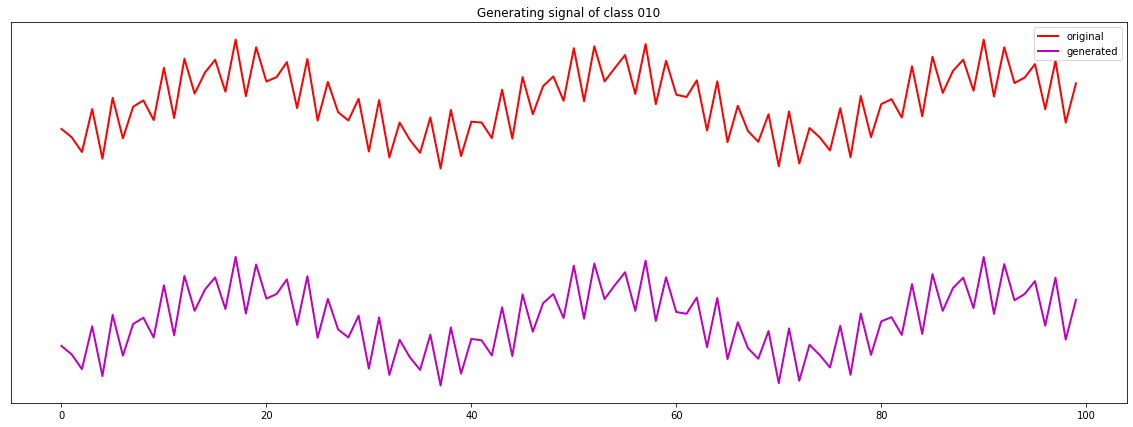

In [66]:
sample = X[18]
original = Y[18]
sample = sample.reshape(1, sample.shape[0], sample.shape[1])
lstm_out_p1 = model.predict(sample)
plt.plot(2 + original.reshape(-1), label="original", linewidth=2, color='r')
plt.plot(lstm_out_p1.reshape(-1), label="generated", linewidth=2, color='m')
plt.title("Generating signal of class 010")
plt.legend(loc = 'upper right')
plt.yticks([])
plt.savefig('lstm_pred_010.png')

In [62]:
np.save('ff_pred_001.npy', out_p)
np.save('ff_pred_010.npy', out_p1)
np.save('lstm_pred_001.npy', lstm_out_p)
np.save('lstm_pred_010.npy', lstm_out_p1)
np.save('data.npy', data)